<a href="https://colab.research.google.com/github/datadigger01/AI-Trade/blob/main/LDA_TopicModel_ex.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# ==========================================
# 1. Package Installation and Imports
# ==========================================
#!pip install --upgrade gensim

# 한글 처리와 토픽모델링 결과에 대한 시각화 패키지 설치
!pip install konlpy
!pip install pyLDAvis

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.4/19.4 MB 33.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 495.9/495.9 kB 28.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 35.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.6/26.6 MB 64.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.0/18.0 MB 88.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.2/38.2 MB 12.9 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
  Attempting uninstall: scipy
    Found existing installation: scipy 1.16.2
    Uninstalling scipy-1.16.2:
      Successfully uninstalled scipy-1.16.2
ERROR: pip's dependency resolver does not currently take into accou

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
import string
import re
from collections import defaultdict


# Gensim imports
import gensim
from gensim import corpora, models
from gensim.models import LdaModel, LsiModel, TfidfModel
from gensim.models.coherencemodel import CoherenceModel
from gensim.parsing.preprocessing import preprocess_string

# Sklearn imports
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

# NLP Libraries
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

# Visualization
from wordcloud import WordCloud
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis

# Download required NLTK data
nltk.download('punkt', quiet=True)
nltk.download('punkt_tab', quiet=True)
nltk.download('stopwords', quiet=True)
nltk.download('wordnet', quiet=True)
nltk.download('omw-1.4', quiet=True)

# Korean NLP
from konlpy.tag import Kkma, Komoran, Okt, Hannanum

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [2]:
# Filter warnings
warnings.filterwarnings("ignore", category=DeprecationWarning, module='jupyter_client')
warnings.filterwarnings("ignore", category=FutureWarning)


# ==========================================
# 2. Data Loading and Initial Setup
# ==========================================

print("=" * 80)
print("TRADE SUCCESS CASE ANALYSIS WITH TF-IDF FILTERED LDA")
print("=" * 80)

# Load data
url = "https://raw.githubusercontent.com/datadigger01/AI-Trade/main/Data/trade_success_case_data.csv"
df = pd.read_csv(url)
print(f"\n데이터 로드 완료: {df.shape[0]}개 행, {df.shape[1]}개 열")
print(df.head())

# Initialize Korean tokenizers
okt = Okt()
kkma = Kkma()
komoran = Komoran()
hannanum = Hannanum()

# ==========================================
# 3. Text Preprocessing Functions
# ==========================================
def combine_specific_words(text, word_pairs):
    """특정 단어 조합을 하나로 합치는 함수"""
    for word_pair in word_pairs:
        # 공백이 있는 형태를 공백 없는 형태로 변환
        text = text.replace(word_pair, word_pair.replace(' ', ''))
    return text

def replace_specific_words(text, word_dict):
    """특정 단어를 다른 단어로 치환하는 함수"""
    for old_word, new_word in word_dict.items():
        text = text.replace(old_word, new_word)
    return text

def clean_text(text):
    """한국어 텍스트 전처리"""
    if pd.isna(text):
        return ""  ## doucument가 결측인경우 NaN return

    #########  특수문자 포함 정제처리할 단어 처리(삭제)
    # HTML 태그 제거
    pattern = r'<[^>]*>'
    text = re.sub(pattern, '', text)
    ## HTML 태그 제거
    ##text = re.sub(r'&[a-z]+;', ' ', text)

    # E-mail제거
    pattern = r'([a-zA-Z0-9_.+-]+@[a-zA-Z0-9-]+\.[a-zA-Z0-9-.]+)'
    text = re.sub(pattern, '', text)

    # URL제거
    pattern = r'(http|ftp|https)://(?:[-\w.]|(?:%[\da-fA-F]{2}))+'
    text = re.sub(pattern, '', text)
    ## Remove URLs
    # text = re.sub(r'http\S+|www.\S+', '', text)

    # 특수문자 제거 (한글, 영문, 공백만 유지)
    text = re.sub(r'[^가-힣a-zA-Z\s]', ' ', text)  # 한글, 영문, 공백만 선택
    #text = re.sub(r'[^가-힣a-zA-Z0-9\s]', ' ', text) # 한글, 영문, 숫자, 공백만 선택
    #text = re.sub(r'[^a-zA-Z0-9\s]', ' ', text) #영문, 숫자, 공백만 선택

    # 한글 자음, 모음 제거
    pattern = r'([ㄱ-ㅎㅏ-ㅣ]+)'  # ㅠㅠ 같은 자음,모음 Character 제거
    text = re.sub(pattern, '', text)

    # 연속된 공백 제거
    text = re.sub(r'\s+', ' ', text)
    # # 연속 공백 정리
    # text = ' '.join(text.split())

    # 특수기호제거
    #pattern = r'[^\w\s]'
    text = re.sub(r'[^\w\s]', '', text)

    # Remove mentions and hashtags
    text = re.sub(r'@\w+|#\w+', '', text)

    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))

    # 영어는 모두 대문자로 전환
    text = text.upper()

    ###########################################################################
    ##  특정 단어에 대한 변환, 조합 및 제거
    ###########################################################################
    # 토큰화 전에 특정 단어를 다른 단어로 치환
    word_replacements = {
        'KOTRA': '코트라',
        '어플리케이션': '애플리케이션',
        '카메라': '캠코더',  # 예시
        # 필요한 단어 치환을 여기에 추가하세요
    }
    text = replace_specific_words(text, word_replacements)

    # 토큰화 전에 특정 단어 조합을 먼저 결합
    word_pairs_to_combine = [
        '성공 사례',        # 성공 사례 -> 성공사례
        '중소 기업',
        '수출 전략',
        '시장 조사',
        '데이터 분석',
        '제품 개발',
        '생활 용품'
        # 필요한 단어 조합을 여기에 추가하세요
    ]
    text = combine_specific_words(text, word_pairs_to_combine)

    # 특정 단어 제거
    remove_words = ['바로가기',
                    '성공사례',
                    'RSQUO','LSQUO','LDQUO','RDQUO',
                    '원문 슬기로운 코트라 활용법',
                    '수출전문위원이 전하는 중소기업 수출성공스토리'
                    ]
    for word in remove_words:
        text = text.replace(word, '')

    return text.strip()


def clean_stopwords(text):
    """영어 불용어 제거 (한글 텍스트에는 효과 제한적)"""
    stop_words = stopwords.words('english')
    return ' '.join([w.lower() for w in text.split() if w not in stop_words and len(w) > 2])

def preprocessing(text):
    """Gensim 전처리"""
    return preprocess_string(text, filters=[lambda x: x.lower()])

# Apply preprocessing
df['bdtCntnt_cleaned'] = df['bdtCntnt'].apply(clean_text)
#df['bdtCntnt_cleaned'] = df['bdtCntnt_cleaned'].apply(clean_stopwords)

print("\n텍스트 전처리 완료")
print(df['bdtCntnt_cleaned'].head())

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

TRADE SUCCESS CASE ANALYSIS WITH TF-IDF FILTERED LDA

데이터 로드 완료: 194개 행, 10개 열
                                            bdtCntnt dataType  ovrofInfo  \
0  보아스테크는 향균과 유독가스 분해 등에 효능이 있는 &lsquo;신비의 광물&rsq...      4유형        NaN   
1  믹스콘컴퍼니 하영은 대표는 피트니스센터에서피트니스센터에서 운동을 하고 나면단백질 보...      4유형        NaN   
2  모트롤은 굴삭기 건설장비에 들어가는 유압 펌프와 모터 등 건설 중장비용 부품 및 장...      4유형        NaN   
3  니즈더펫(NEEDS THE PET)은 반려동물 제품 중에서도 중&middot;대형견...      4유형        NaN   
4  의류학과 출신 꼬꼬잠 박정혜 대표는 첫째 아이를 낳고 1년 동안 바닥에 누워 잠을 ...      4유형        NaN   

   dmgeAmt  fraudType     othbcDt  bbstxSn  \
0      NaN        NaN  2022-12-09   199116   
1      NaN        NaN  2022-11-04   198065   
2      NaN        NaN  2022-10-19   197606   
3      NaN        NaN  2022-09-20   196935   
4      NaN        NaN  2022-09-02   196519   

                                 titl natn regn  
0                SNS 마케팅을 통해 해외 판로 개척   북미   미국  
1  해외시장조사를 통한 타겟 시장 선정 및 바이어 발굴로 수출성공   북미   미국  
2              FTA 활용으로 제품의 가격 경쟁력 제고

In [ ]:
print(df.info())
df

In [3]:
# ==========================================
# 4. Korean Tokenization
# ==========================================

print("\n" + "=" * 60)
print("한국어 토큰화 진행")
print("=" * 60)

# 명사 추출 (기본 설정)
tokenized_noun = df['bdtCntnt_cleaned'].apply(lambda x: okt.nouns(x) if x else [])
# tokenized_noun = df['bdtCntnt_cleaned'].apply(lambda x: kkma.nouns(x) if x else [])
# tokenized_noun = df['bdtCntnt_cleaned'].apply(lambda x: komoran.nouns(x) if x else [])
# tokenized_noun = df['bdtCntnt_cleaned'].apply(lambda x: hannanum.nouns(x) if x else [])

# 형태소 추출 (옵션)
#tokenized_morphs = df['bdtCntnt_cleaned'].apply(lambda x: okt.morphs(x, stem=True, norm=True) if x else [])
# 어절 추출 (옵션)
# tokenized_phrases = df['bdtCntnt_cleaned'].apply(lambda x: okt.phrases(x) if x else [])

# 한국어 불용어 리스트
korean_stopwords = [
    '의', '가', '이', '은', '들', '는', '좀', '잘', '걍', '과', '도', '를', '으로', '자',
    '에', '와', '한', '하다', '을', '를', '에서', '으로', '로', '에게', '의해', '까지',
    '수', '것', '등', '및', '그', '저', '것', '또', '또한', '더', '매우', '정말',
    '위해', '통해', '대한', '관한', '따라', '대해', '년', '월', '일', '개', '명', '곳'
]

# 불용어 제거 및 2글자 이상 단어만 선택
tokens = tokenized_noun.apply(
    lambda nouns: [noun for noun in nouns if noun not in korean_stopwords and len(noun) > 1]
)
# tokens = tokenized_phrases.apply(
#     lambda phrases: [phrase for phrase in phrases if phrase not in korean_stopwords and len(phrase) > 1]
# )

# 기본적으로 명사 사용
tokenized_abst = tokens

print(f"토큰화(명사만 추출) 완료: {len(tokenized_abst)}개 문서")
print("\n샘플 토큰화 결과 (처음 5개 문서):")
for i in range(min(5, len(tokenized_abst))):
    print(f"문서 {i+1}: {tokenized_abst[i][:10]}...")


한국어 토큰화 진행
토큰화(명사만 추출) 완료: 194개 문서

샘플 토큰화 결과 (처음 5개 문서):
문서 1: ['보아스', '테크', '향균', '유독가스', '분해', '효능', '신비', '광물', '라이트', '활용']...
문서 2: ['믹스', '컴퍼니', '대표', '피트니스', '센터', '피트니스', '센터', '운동', '단백질', '보충']...
문서 3: ['트롤', '굴삭기', '건설', '장비', '유압', '펌프', '모터', '건설', '중장', '비용']...
문서 4: ['더펫', '반려동물', '제품', '대형견', '아웃도어', '제품', '생산', '활동', '대형견', '산책']...
문서 5: ['의류', '학과', '출신', '꼬꼬', '박정혜', '대표', '첫째', '아이', '동안', '바닥']...


In [4]:
print(tokenized_abst[0])

['보아스', '테크', '향균', '유독가스', '분해', '효능', '신비', '광물', '라이트', '활용', '탈취', '화장품', '생활용품', '제작', '판매', '회사', '최영준', '대표', '년대', '가습기', '살균제', '사건', '라돈', '침대', '사건', '경험', '우리', '생활', '화학물질', '얼마나', '침투', '체감', '친환경', '생활', '용품', '개발', '갈망', '창업', '회사', '설립', '라이트', '소재', '제품', '개발', '노력', '최영준', '대표', '탈취', '화장품', '제품', '와디', '펀딩', '스킨', '미스트', '라이트', '비누', '매출', '증가', '만큼', '보아스', '테크', '제품', '소비자', '로부터', '반응', '제품', '보아스', '테크', '동안', '국내', '온라인', '입점', '팝업', '행사', '참여', '판매', '활동', '보아스', '테크', '수출', '부터', '제품', '가짓수', '적지', '제품', '특장점', '때문', '차별성', '해외', '진출', '예상', '최영준', '대표', '수출', '본격', '대전', '세종', '코트라', '원단', '연락', '유관', '기관', '수출', '마케팅', '사업', '적기', '지원', '기업', '수출', '기업', '사업', '참여', '보아스', '테크', '이동', '코트라', '수출', '위원', '멘토링', '테스트', '마케팅', '화상', '상담', '진행', '중국', '바이어', '소통', '사내', '수출', '전담', '인력', '바이어', '이메일', '대응', '하나', '어려움', '보아스', '테크', '하나', '위원', '하나요', '수출', '절박', '막상', '바이어', '연결', '수출', '걱정', '코트라', '이동', '코트라', '수출', '위원', '만남', '직원', '생각', '부담', '도움', '요청', 

In [5]:
# ==========================================
# 5. TF-IDF Term Filtering Class
# ==========================================

class TfidfTermFilter:
    """TF-IDF 기반 용어 필터링 클래스"""

    def __init__(self):
        self.dictionary = None
        self.corpus = None
        self.tfidf_model = None
        self.selected_terms = set()

    def create_initial_corpus(self, documents, no_below=5, no_above=0.6):
        """초기 코퍼스 생성"""
        self.dictionary = corpora.Dictionary(documents)
        print(f"\n초기 어휘 크기: {len(self.dictionary)}")

        # 기본 빈도 필터링
        self.dictionary.filter_extremes(no_below=no_below, no_above=no_above)
        print(f"빈도 필터링 후: {len(self.dictionary)}")

        self.corpus = [self.dictionary.doc2bow(text) for text in documents]
        return self.dictionary, self.corpus

    def calculate_tfidf(self):
        """TF-IDF 계산"""
        self.tfidf_model = TfidfModel(self.corpus, normalize=True)
        return self.tfidf_model

    def filter_by_threshold(self, min_tfidf=0.1, max_tfidf=0.8):
        """임계값 기반 필터링"""
        print("\n[방법 1] 임계값 기반 TF-IDF 필터링")
        print(f"임계값: {min_tfidf} ~ {max_tfidf}")

        term_scores = defaultdict(list)

        # 각 용어의 TF-IDF 점수 수집
        for doc_bow in self.corpus:
            doc_tfidf = self.tfidf_model[doc_bow]
            for word_id, score in doc_tfidf:
                term_scores[word_id].append(score)

        # 평균 점수 기반 필터링
        selected_terms = set()
        for word_id, scores in term_scores.items():
            avg_score = np.mean(scores)
            if min_tfidf <= avg_score <= max_tfidf:
                selected_terms.add(word_id)

        print(f"선택된 용어: {len(selected_terms)} / {len(self.dictionary)}")
        return selected_terms

    def filter_top_k_per_doc(self, k=20):
        """문서별 상위 K개 용어 선택"""
        print(f"\n[방법 2] 문서별 상위 {k}개 용어 필터링")

        selected_terms = set()

        for doc_idx, doc_bow in enumerate(self.corpus):
            doc_tfidf = self.tfidf_model[doc_bow]
            # 상위 k개 용어 선택
            sorted_terms = sorted(doc_tfidf, key=lambda x: x[1], reverse=True)[:k]
            for word_id, score in sorted_terms:
                selected_terms.add(word_id)

        print(f"선택된 용어: {len(selected_terms)} / {len(self.dictionary)}")
        return selected_terms

    def filter_top_k_global(self, k=500):
        """전역 상위 K개 용어 선택"""
        print(f"\n[방법 3] 전역 상위 {k}개 용어 필터링")

        # 각 용어의 최대 TF-IDF 점수 계산
        global_scores = defaultdict(float)

        for doc_bow in self.corpus:
            doc_tfidf = self.tfidf_model[doc_bow]
            for word_id, score in doc_tfidf:
                global_scores[word_id] = max(global_scores[word_id], score)

        # 상위 k개 선택
        sorted_terms = sorted(global_scores.items(), key=lambda x: x[1], reverse=True)[:k]
        selected_terms = set([word_id for word_id, _ in sorted_terms])

        print(f"선택된 용어: {len(selected_terms)} / {len(self.dictionary)}")

        # 상위 20개 용어 출력
        print("\n상위 20개 중요 용어:")
        for i, (word_id, score) in enumerate(sorted_terms[:20]):
            print(f"{i+1:2d}. {self.dictionary[word_id]:15s} - TF-IDF: {score:.4f}")

        return selected_terms

    def filter_percentile(self, lower=20, upper=90):
        """백분위수 기반 필터링"""
        print(f"\n[방법 4] 백분위수 기반 필터링 ({lower}~{upper} percentile)")

        # 모든 TF-IDF 점수 수집
        all_scores = []
        term_max_scores = defaultdict(float)

        for doc_bow in self.corpus:
            doc_tfidf = self.tfidf_model[doc_bow]
            for word_id, score in doc_tfidf:
                all_scores.append(score)
                term_max_scores[word_id] = max(term_max_scores[word_id], score)

        # 백분위수 계산
        lower_threshold = np.percentile(all_scores, lower)
        upper_threshold = np.percentile(all_scores, upper)

        print(f"임계값: {lower_threshold:.4f} ~ {upper_threshold:.4f}")

        # 필터링
        selected_terms = set()
        for word_id, max_score in term_max_scores.items():
            if lower_threshold <= max_score <= upper_threshold:
                selected_terms.add(word_id)

        print(f"선택된 용어: {len(selected_terms)} / {len(self.dictionary)}")
        return selected_terms

    def create_filtered_corpus(self, documents, selected_terms):
        """필터링된 코퍼스 생성"""
        # 선택된 용어만으로 새 딕셔너리 생성
        selected_tokens = [self.dictionary[tid] for tid in selected_terms if tid in self.dictionary]
        filtered_dict = corpora.Dictionary([selected_tokens])

        # 필터링된 코퍼스 생성
        filtered_corpus = []
        for doc in documents:
            filtered_doc = [token for token in doc if token in filtered_dict.token2id]
            filtered_corpus.append(filtered_dict.doc2bow(filtered_doc))

        return filtered_dict, filtered_corpus


In [10]:
# ==========================================
# 6. LDA Modeling with Filtered Terms
# ==========================================

def run_lda_with_filtering(tokenized_docs, filtering_method='threshold',
                          num_topics=5, **filter_params):
    """TF-IDF 필터링 후 LDA 모델링"""

    print("\n" + "=" * 80)
    print(f"TF-IDF 필터링 LDA 모델링 - {filtering_method.upper()} 방법")
    print("=" * 80)

    # TF-IDF 필터 초기화
    filter = TfidfTermFilter()

    # 초기 코퍼스 생성
    dictionary, corpus = filter.create_initial_corpus(
        tokenized_docs,
        no_below=filter_params.get('no_below', 5),
        no_above=filter_params.get('no_above', 0.6)
    )

    # TF-IDF 계산
    tfidf_model = filter.calculate_tfidf()

    # 필터링 방법 선택
    if filtering_method == 'threshold':
        selected_terms = filter.filter_by_threshold(
            min_tfidf=filter_params.get('min_tfidf', 0.1),
            max_tfidf=filter_params.get('max_tfidf', 0.8)
        )
    elif filtering_method == 'top_k_doc':
        selected_terms = filter.filter_top_k_per_doc(
            k=filter_params.get('k', 20)
        )
    elif filtering_method == 'top_k_global':
        selected_terms = filter.filter_top_k_global(
            k=filter_params.get('k', 1000)
        )
    elif filtering_method == 'percentile':
        selected_terms = filter.filter_percentile(
            lower=filter_params.get('lower', 20),
            upper=filter_params.get('upper', 90)
        )
    else:
        # 필터링 없이 전체 사용
        selected_terms = set(dictionary.keys())
        print("필터링 없이 전체 용어 사용")

    # 필터링된 코퍼스 생성
    filtered_dict, filtered_corpus = filter.create_filtered_corpus(
        tokenized_docs, selected_terms
    )

    print(f"\n최종 어휘 크기: {len(filtered_dict)}")
    print(f"어휘 감소율: {(1 - len(filtered_dict)/len(dictionary))*100:.1f}%")

    # LDA 모델 학습
    print(f"\nLDA 모델 학습 (토픽 수: {num_topics})")

    # TF-IDF 가중치 적용 옵션
    use_tfidf_weights = filter_params.get('use_tfidf_weights', False)

    if use_tfidf_weights:
        # TF-IDF 가중치를 적용한 코퍼스로 학습
        print("TF-IDF 가중치 적용")
        tfidf_filtered = TfidfModel(filtered_corpus)
        corpus_for_lda = tfidf_filtered[filtered_corpus]
    else:
        # 필터링된 일반 코퍼스로 학습
        print("일반 BOW 코퍼스 사용 (필터링만 적용)")
        corpus_for_lda = filtered_corpus

    # LDA 모델 학습
    lda_model = LdaModel(
        corpus=corpus_for_lda,
        num_topics=num_topics,
        id2word=filtered_dict,
        eta='auto',
        alpha='auto',
        iterations=50,
        passes=10,
        eval_every=10,
        per_word_topics=True,
        random_state=42
    )

    # 토픽 출력
    print("\n발견된 토픽:")
    topics = lda_model.print_topics(num_words=10)
    for idx, topic in topics:
        print(f"\n토픽 {idx}:")
        # 토픽 단어를 보기 좋게 정리
        words = []
        for word_prob in topic.split(' + '):
            parts = word_prob.split('*')
            if len(parts) == 2:
                prob = float(parts[0])
                word = parts[1].strip('"')
                words.append(f"{word}({prob:.3f})")
        print(f"  {', '.join(words[:5])}")
        if len(words) > 5:
            print(f"  {', '.join(words[5:10])}")

    # Coherence 계산
    coherence_model = CoherenceModel(
        model=lda_model,
        texts=tokenized_docs,
        dictionary=filtered_dict,
        coherence='c_v'
    )
    coherence_score = coherence_model.get_coherence()
    print(f"\nCoherence Score: {coherence_score:.4f}")

    return lda_model, filtered_dict, filtered_corpus, coherence_score

In [11]:
# ==========================================
# 7. Compare Different Filtering Methods
# ==========================================

def compare_filtering_methods(tokenized_docs, num_topics=5):
    """다양한 필터링 방법 비교"""

    print("\n" + "=" * 80)
    print("TF-IDF 필터링 방법 비교")
    print("=" * 80)

    results = []
    models = {}

    # 1. 필터링 없음 (기준선)
    print("\n[기준선] 필터링 없음")
    params = {'no_below': 5, 'no_above': 0.5}
    model, dict_, corpus, coherence = run_lda_with_filtering(
        tokenized_docs, 'none', num_topics, **params
    )
    results.append({
        'method': 'No Filtering',
        'vocab_size': len(dict_),
        'coherence': coherence
    })
    models['none'] = (model, dict_, corpus)

    # 2. 임계값 기반 필터링
    params = {'min_tfidf': 0.05, 'max_tfidf': 0.6, 'no_below': 5, 'no_above': 0.5}
    model, dict_, corpus, coherence = run_lda_with_filtering(
        tokenized_docs, 'threshold', num_topics, **params
    )
    results.append({
        'method': 'Threshold',
        'vocab_size': len(dict_),
        'coherence': coherence
    })
    models['threshold'] = (model, dict_, corpus)

    # 3. 문서별 상위 K
    params = {'k': 20, 'no_below': 5, 'no_above': 0.6}
    model, dict_, corpus, coherence = run_lda_with_filtering(
        tokenized_docs, 'top_k_doc', num_topics, **params
    )
    results.append({
        'method': 'Top-K/Doc',
        'vocab_size': len(dict_),
        'coherence': coherence
    })
    models['top_k_doc'] = (model, dict_, corpus)

    # 4. 전역 상위 K
    params = {'k': 300, 'no_below': 5, 'no_above': 0.6}
    model, dict_, corpus, coherence = run_lda_with_filtering(
        tokenized_docs, 'top_k_global', num_topics, **params
    )
    results.append({
        'method': 'Global Top-K',
        'vocab_size': len(dict_),
        'coherence': coherence
    })
    models['top_k_global'] = (model, dict_, corpus)

    # 5. 백분위수 기반
    params = {'lower': 20, 'upper': 90, 'no_below': 5, 'no_above': 0.6}
    model, dict_, corpus, coherence = run_lda_with_filtering(
        tokenized_docs, 'percentile', num_topics, **params
    )
    results.append({
        'method': 'Percentile',
        'vocab_size': len(dict_),
        'coherence': coherence
    })
    models['percentile'] = (model, dict_, corpus)

    # 결과 출력
    results_df = pd.DataFrame(results)
    print("\n" + "=" * 80)
    print("비교 결과")
    print("=" * 80)
    print(results_df.to_string())

    # 시각화
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

    # Coherence 비교
    ax1.bar(results_df['method'], results_df['coherence'])
    ax1.set_xlabel('필터링 방법')
    ax1.set_ylabel('Coherence Score')
    ax1.set_title('Coherence Score 비교')
    ax1.tick_params(axis='x', rotation=45)

    # 어휘 크기 비교
    ax2.bar(results_df['method'], results_df['vocab_size'])
    ax2.set_xlabel('필터링 방법')
    ax2.set_ylabel('어휘 크기')
    ax2.set_title('필터링 후 어휘 크기')
    ax2.tick_params(axis='x', rotation=45)

    plt.tight_layout()
    plt.show()

    return results_df, models



최종 모델: Global Top-K TF-IDF 필터링 LDA

TF-IDF 필터링 LDA 모델링 - THRESHOLD 방법

초기 어휘 크기: 7299
빈도 필터링 후: 1538

[방법 1] 임계값 기반 TF-IDF 필터링
임계값: 0.1 ~ 0.8
선택된 용어: 209 / 1538

최종 어휘 크기: 209
어휘 감소율: 86.4%

LDA 모델 학습 (토픽 수: 6)
일반 BOW 코퍼스 사용 (필터링만 적용)

발견된 토픽:

토픽 0:
  에스(0.114), 미얀마(0.060), 건설(0.049), 키트(0.033), 기계(0.031)
  프랑스(0.026), 부품(0.025), 의료기기(0.024), 보안(0.022), 파워(0.022)

토픽 1:
  화장품(0.102), 마스크(0.042), 화상(0.039), 피부(0.038), 교육(0.036)
  이동(0.029), 한류(0.028), 매장(0.026), 사회(0.025), 전자(0.020)

토픽 2:
  아이(0.102), 선박(0.043), 유아(0.042), 부품(0.042), 비누(0.035)
  전기(0.033), 엄마(0.032), 자동차(0.032), 용품(0.031), 펌프(0.029)

토픽 3:
  부품(0.054), 폴란드(0.050), 커피(0.042), 건축(0.038), 스마트(0.035)
  대하(0.035), 패션(0.029), 바르샤바(0.028), 러시아(0.026), 품종(0.026)

토픽 4:
  식품(0.122), 설비(0.083), 홍삼(0.051), 농업(0.035), 별기(0.032)
  태양광(0.026), 우즈베키스탄(0.026), 음료(0.024), 영어(0.023), 콜롬비아(0.022)

토픽 5:
  비즈니스(0.204), 파트너(0.204), 태국(0.042), 기계(0.037), 엔지니어링(0.037)
  인도(0.029), 러시아(0.021), 건설(0.020), 부착(0.020), 캄보디아(0.017)

Coherence Sc

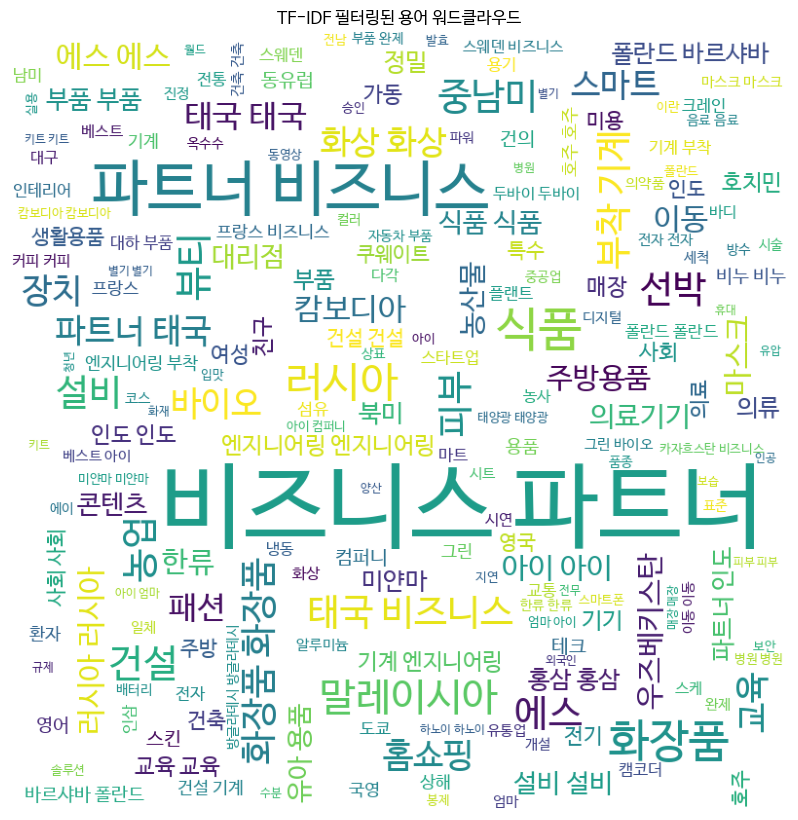


다양한 필터링 방법 비교를 원하시면 아래 코드를 실행하세요:
# comparison_df, all_models = compare_filtering_methods(tokenized_abst, num_topics=5)

필터링된 딕셔너리 저장 완료: tfidf_filtered_dictionary.txt

분석 완료!
최종 결과:
- 필터링 방법: threshold
- 최종 어휘 크기: 209
- 토픽 수: 5
- Coherence Score: 0.4457


In [12]:
# ==========================================
# 8. Main Execution
# ==========================================

# 최적 필터링 방법으로 LDA 실행 (Global Top-K 추천)
print("\n" + "=" * 80)
print("최종 모델: Global Top-K TF-IDF 필터링 LDA")
print("=" * 80)

# Global Top-K 방법 사용 (일반적으로 좋은 성능)
best_params = {
    'k': 1000,  # 상위 k개 용어 선택
    'no_below': 5,
    'no_above': 0.6,
    'use_tfidf_weights': False  # 필터링만 하고 가중치는 사용 안함
}

lda_model_best, dictionary_best, corpus_best, coherence_best = run_lda_with_filtering(
    tokenized_abst,
    # filtering_method='No Filtering',
    # filtering_method='top_k_global',
    filtering_method='threshold',
    # filtering_method='percentile',
    # filtering_method='Top-K/Doc',
    num_topics=6,
    **best_params
)

# ==========================================
# 9. Visualization
# ==========================================

print("\n" + "=" * 80)
print("시각화")
print("=" * 80)

# pyLDAvis 시각화
try:
    pyLDAvis.enable_notebook()
    vis = pyLDAvis.gensim_models.prepare(
        topic_model=lda_model_best,
        corpus=corpus_best,
        dictionary=dictionary_best,
        sort_topics=False
    )
    pyLDAvis.display(vis)

    # HTML 저장 (옵션)
    pyLDAvis.save_html(vis, 'tfidf_filtered_lda_visualization.html')
    print("LDA 시각화 생성 완료")
except Exception as e:
    print(f"pyLDAvis 시각화 실패: {e}")

# 워드클라우드 생성
try:
    # 한국어 폰트 설치 (Colab 환경)
    import subprocess
    subprocess.run(['apt-get', 'update', '-qq'], check=True)
    subprocess.run(['apt-get', 'install', 'fonts-nanum', '-qq'], check=True)

    import matplotlib.font_manager as fm
    fm.fontManager.addfont('/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf')
    plt.rc('font', family='NanumBarunGothic')

    # 필터링된 용어로만 워드클라우드 생성
    filtered_words = []
    for doc in tokenized_abst:
        filtered_doc = [token for token in doc if token in dictionary_best.token2id]
        filtered_words.extend(filtered_doc)

    words_string = ' '.join(filtered_words)

    wordcloud = WordCloud(
        width=800,
        height=800,
        background_color='white',
        min_font_size=10,
        font_path='/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
    ).generate(words_string)

    plt.figure(figsize=(8, 8))
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.title("TF-IDF 필터링된 용어 워드클라우드")
    plt.tight_layout(pad=0)
    plt.show()

except Exception as e:
    print(f"워드클라우드 생성 실패: {e}")

# ==========================================
# 10. Compare All Methods (Optional)
# ==========================================

# 모든 필터링 방법 비교 (실행하려면 주석 해제)
print("\n다양한 필터링 방법 비교를 원하시면 아래 코드를 실행하세요:")
print("# comparison_df, all_models = compare_filtering_methods(tokenized_abst, num_topics=5)")

#comparison_df, all_models = compare_filtering_methods(tokenized_abst, num_topics=5)

# ==========================================
# 11. Save Results
# ==========================================

# 딕셔너리 저장
dictionary_best.save_as_text('tfidf_filtered_dictionary.txt')
print("\n필터링된 딕셔너리 저장 완료: tfidf_filtered_dictionary.txt")

print("\n" + "=" * 80)
print("분석 완료!")
print("=" * 80)
print(f"최종 결과:")
print(f"- 필터링 방법: threshold")
print(f"- 최종 어휘 크기: {len(dictionary_best)}")
print(f"- 토픽 수: 5")
print(f"- Coherence Score: {coherence_best:.4f}")